# Imports

In [77]:
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from lightgbm import LGBMClassifier, log_evaluation, early_stopping


rc = {
    "axes.facecolor": "#2E3440",
    "figure.facecolor": "#2E3440",
    "axes.edgecolor": "#4C566A",
    "grid.color": "#4C566A",
    "font.family": "JetBrains Mono",
    "text.color": "#FFFFFF",
    "axes.labelcolor": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "grid.alpha": 0.4,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "legend.title_fontsize": 10
}

bp_props = {
    'boxprops':{'facecolor':'#037d97', 'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'},
    'flierprops':{'marker':'x', 'markeredgecolor':'white'}
}

sns.set(rc=rc)

In [43]:
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')

orig_df = pd.read_csv('original.csv').drop('RowNumber', axis=1)

target_var = 'Exited'
cat_features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
num_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

# Data Description

In [8]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [9]:
orig_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


## Shape and Columns

In [18]:
print('Train Descriptors')
print(f'Shape: {train_df.shape}')
print(f'Columns : {train_df.columns}')
print('')
print('Test Descriptors')
print(f'Shape: {test_df.shape}')
print(test_df.columns)
print('')
print('Original Description')
print(f'Shape: {orig_df.shape}')
print(orig_df.columns)

Train Descriptors
Shape: (165034, 13)
Columns : Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

Test Descriptors
Shape: (110023, 12)
Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')

Original Description
Shape: (10002, 13)
Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')


## Missing Values

In [19]:
null_values = {'column': [], 'train_null_values': [], 'test_null_values': []}

for col in test_df.columns:
    train_col_null = train_df[col].isna().sum()
    test_col_null = test_df[col].isna().sum()
    
    null_values['column'].append(col)
    null_values['train_null_values'].append(train_col_null)
    null_values['test_null_values'].append(test_col_null)
    
null_values = pd.DataFrame(null_values)
null_values['train_total'] = train_df.shape[0]
null_values['test_total'] = test_df.shape[0]
null_values['train_null_perc'] = null_values['train_null_values'] / null_values['train_total']
null_values['test_null_perc'] = null_values['test_null_values'] / null_values['test_total']
null_values.sort_values(by='train_null_perc', inplace=True, ascending=False)

null_values.style.format({'train_null_perc': '{:.0%}',
                          'test_null_perc': '{:.0%}'})

,column,train_null_values,test_null_values,train_total,test_total,train_null_perc,test_null_perc
0,CustomerId,0,0,165034,110023,0%,0%
1,Surname,0,0,165034,110023,0%,0%
2,CreditScore,0,0,165034,110023,0%,0%
3,Geography,0,0,165034,110023,0%,0%
4,Gender,0,0,165034,110023,0%,0%
5,Age,0,0,165034,110023,0%,0%
6,Tenure,0,0,165034,110023,0%,0%
7,Balance,0,0,165034,110023,0%,0%
8,NumOfProducts,0,0,165034,110023,0%,0%
9,HasCrCard,0,0,165034,110023,0%,0%


In [20]:
null_values_per_row = train_df.isna().sum(axis=1)
pd.DataFrame(null_values_per_row.value_counts().sort_index())

,count
0,165034


In [21]:
missing_values = {'column': [], 'only_in_train': [], 'only_in_test': []}

for col in cat_features:
    train_col_unique = train_df[col].unique()
    test_col_unique = test_df[col].unique()
    
    missing_values['column'].append(col)
    missing_values['only_in_train'].append([f for f in train_col_unique if f not in test_col_unique])
    missing_values['only_in_test'].append([f for f in test_col_unique if f not in train_col_unique])

missing_values = pd.DataFrame(missing_values)
missing_values

,column,only_in_train,only_in_test
0,Geography,[],[]
1,Gender,[],[]
2,HasCrCard,[],[]
3,IsActiveMember,[],[]


## Adversarial Testing

### Train vs Test

In [22]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

-----> Fold 1 <-----
: AUC ROC = 0.50254750146276
-----> Fold 2 <-----
: AUC ROC = 0.5017941634095581
-----> Fold 3 <-----
: AUC ROC = 0.5026815028707637
-----> Fold 4 <-----
: AUC ROC = 0.5044215094141196
-----> Fold 5 <-----
: AUC ROC = 0.501967542040692
--> Overall results for out of fold predictions
: AUC ROC = 0.5023507230558407


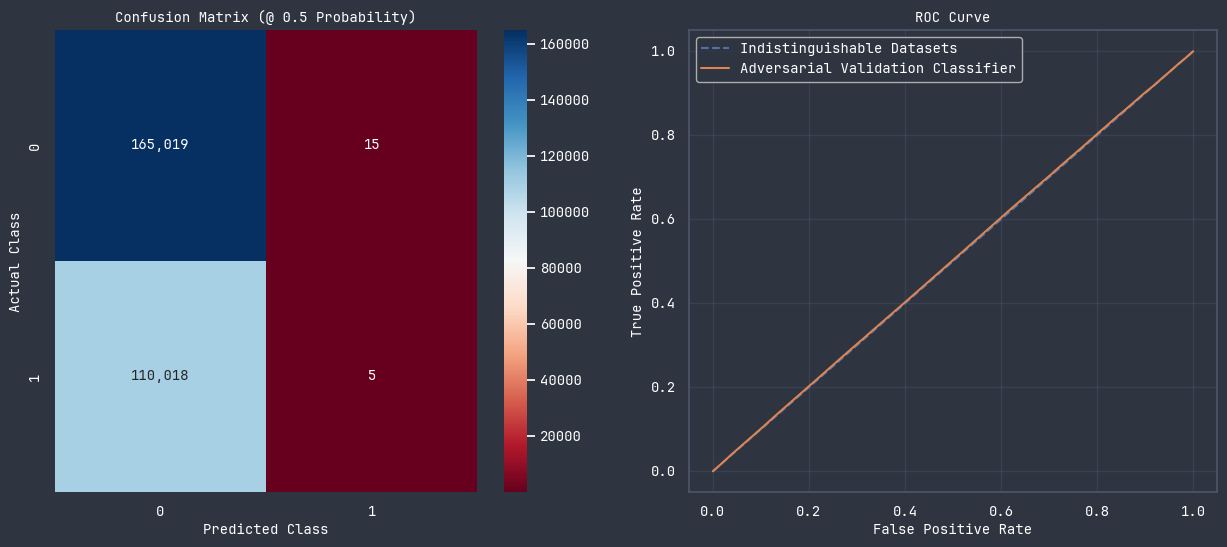

In [23]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

### Train/Test Original

In [24]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=0), orig_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

-----> Fold 1 <-----
: AUC ROC = 0.7136751065830153
-----> Fold 2 <-----
: AUC ROC = 0.6934953335951133
-----> Fold 3 <-----
: AUC ROC = 0.7007878751896424
-----> Fold 4 <-----
: AUC ROC = 0.7080598858844478
-----> Fold 5 <-----
: AUC ROC = 0.7031869493314474
--> Overall results for out of fold predictions
: AUC ROC = 0.7036769640294956


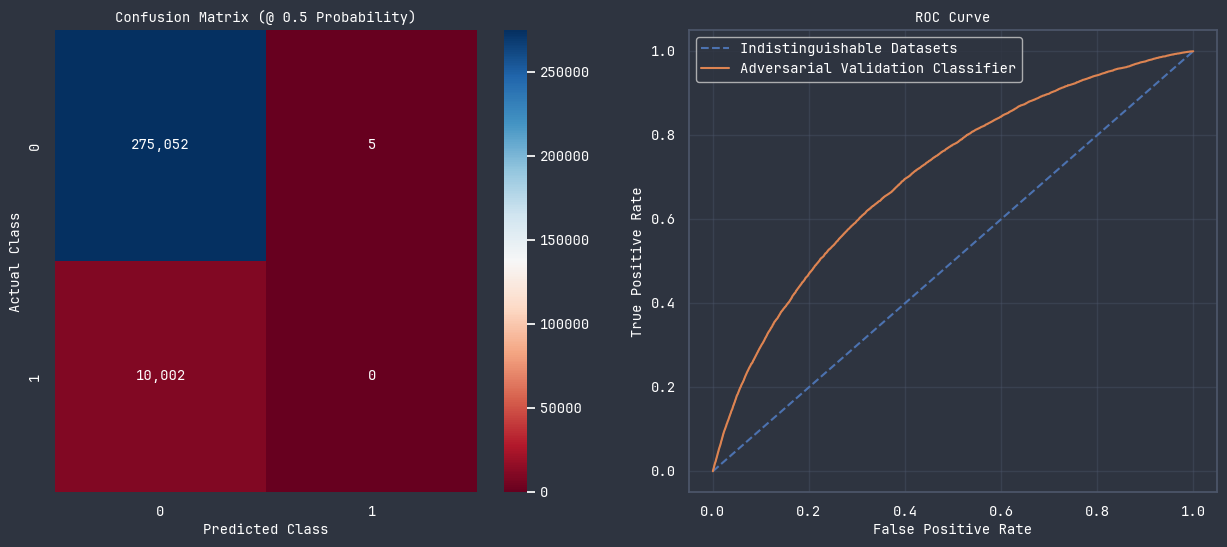

In [25]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

# Exploratory Data Analysis

## Variable Distribution

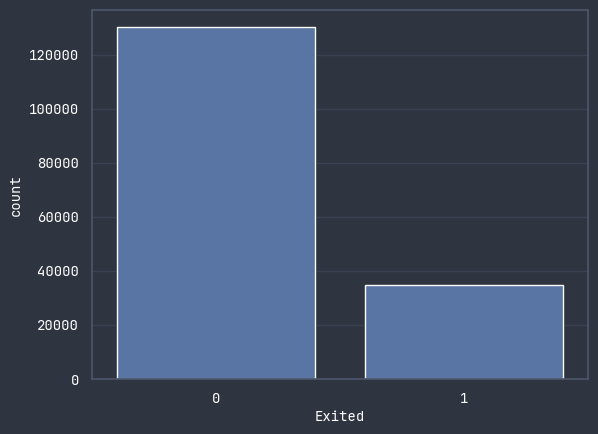

In [27]:
sns.countplot(data=train_df, x=target_var)
plt.show()

## Variable Correlation

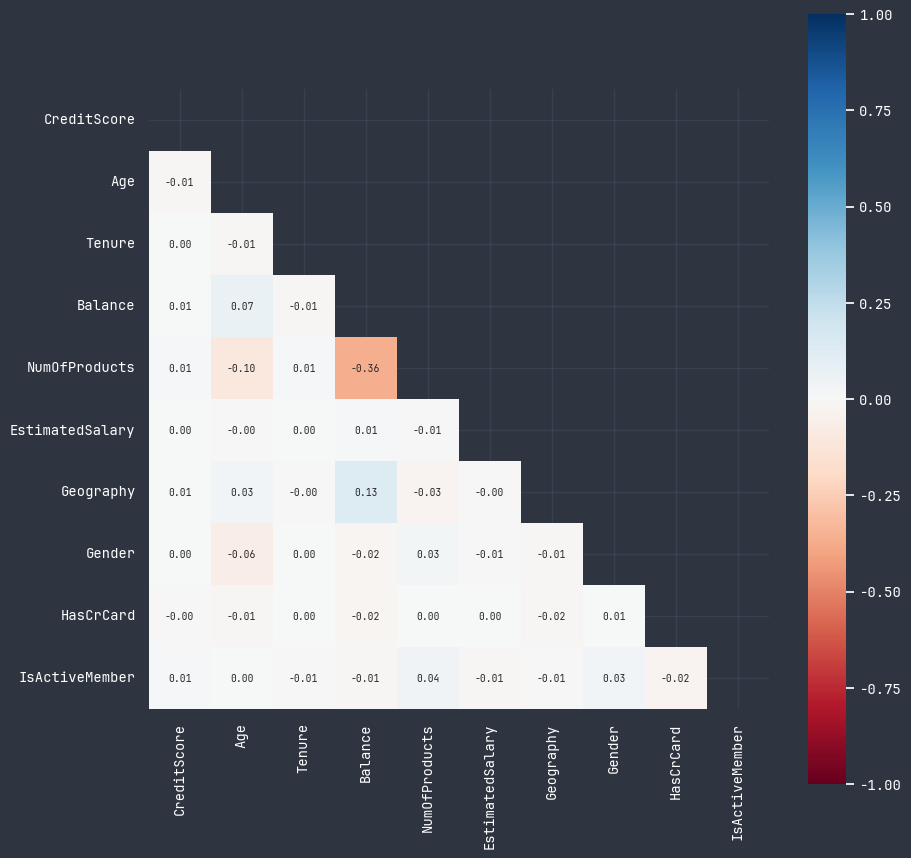

In [37]:
df = pd.concat([train_df[num_features + cat_features], test_df[num_features + cat_features]], ignore_index=True)
le = LabelEncoder()
df['Geography'] = le.fit_transform(df['Geography'])
df['Gender'] = le.fit_transform(df['Gender'])

df_corr = df.corr(method='pearson')
mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, mask=mask, annot=True, annot_kws={"size": 7}, fmt='.2f', cmap='RdBu', square=True, vmin=-1, vmax=1)
plt.show()

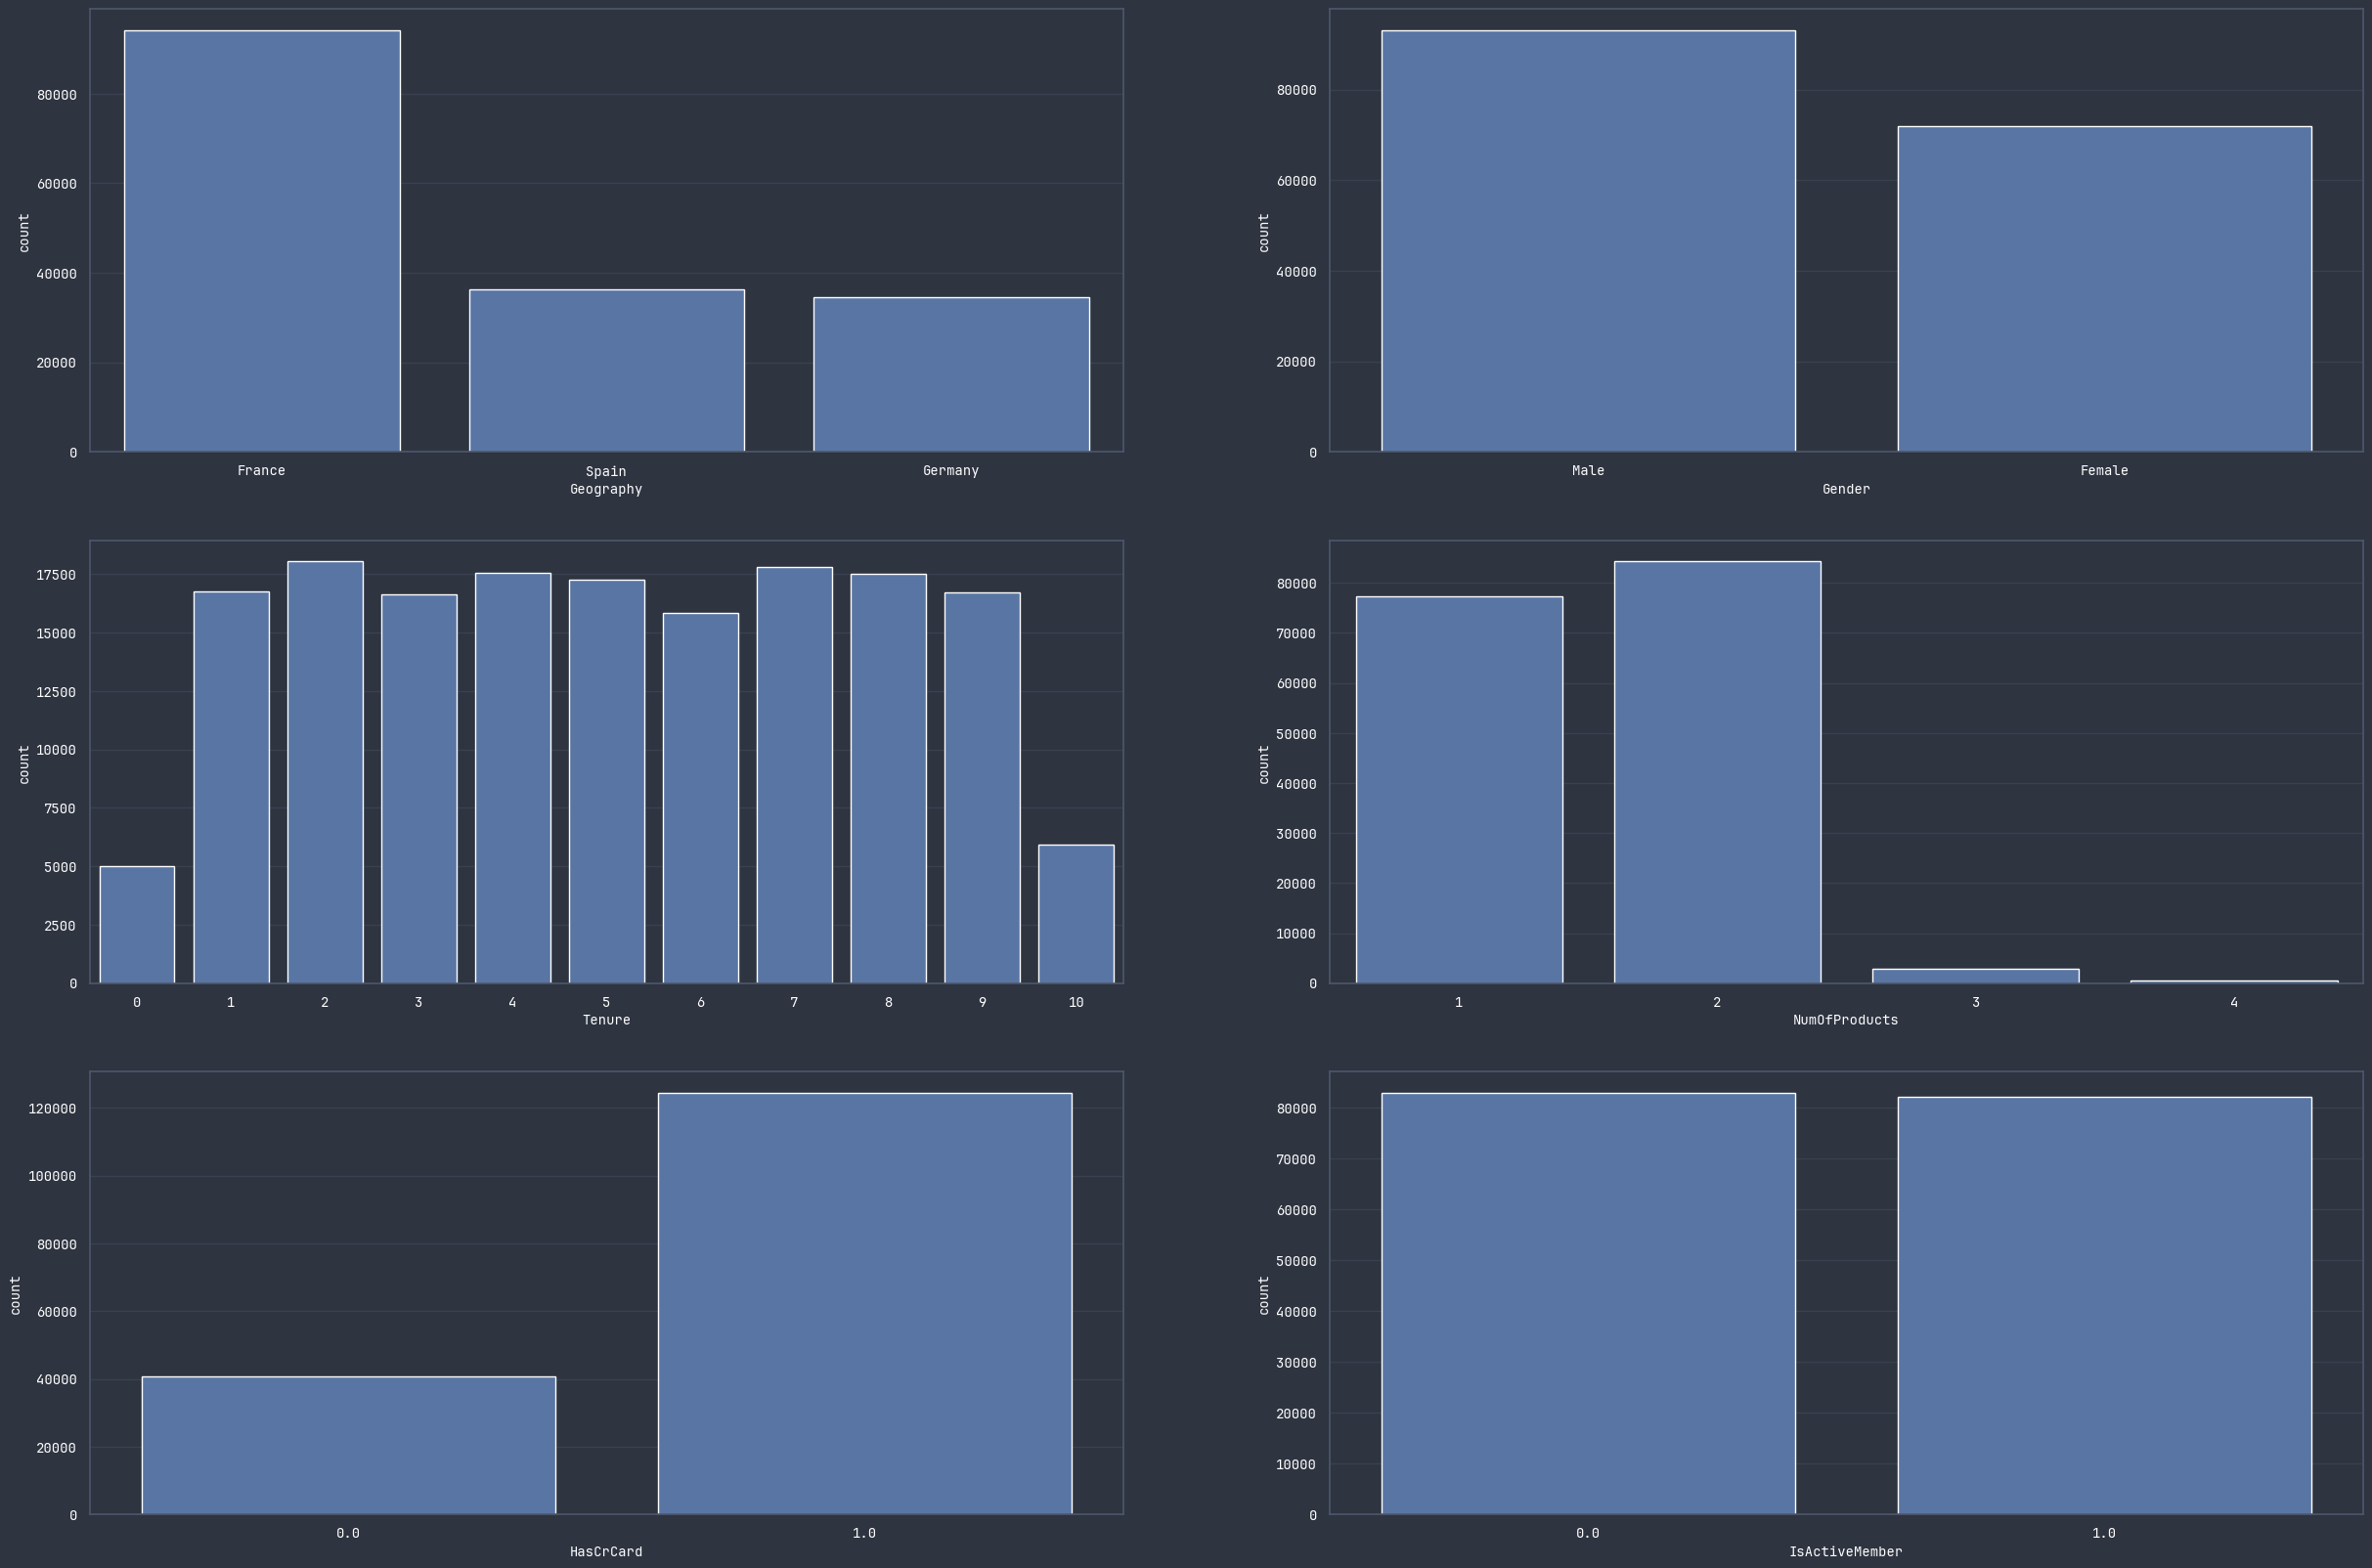

In [50]:
fig, axs = plt.subplots(nrows=len(cat_features)//2, ncols=2, figsize=(30,20))
axs = axs.flatten()

for i, feat in enumerate(cat_features):
    sns.countplot(data=train_df, x=feat, ax=axs[i])
plt.show()

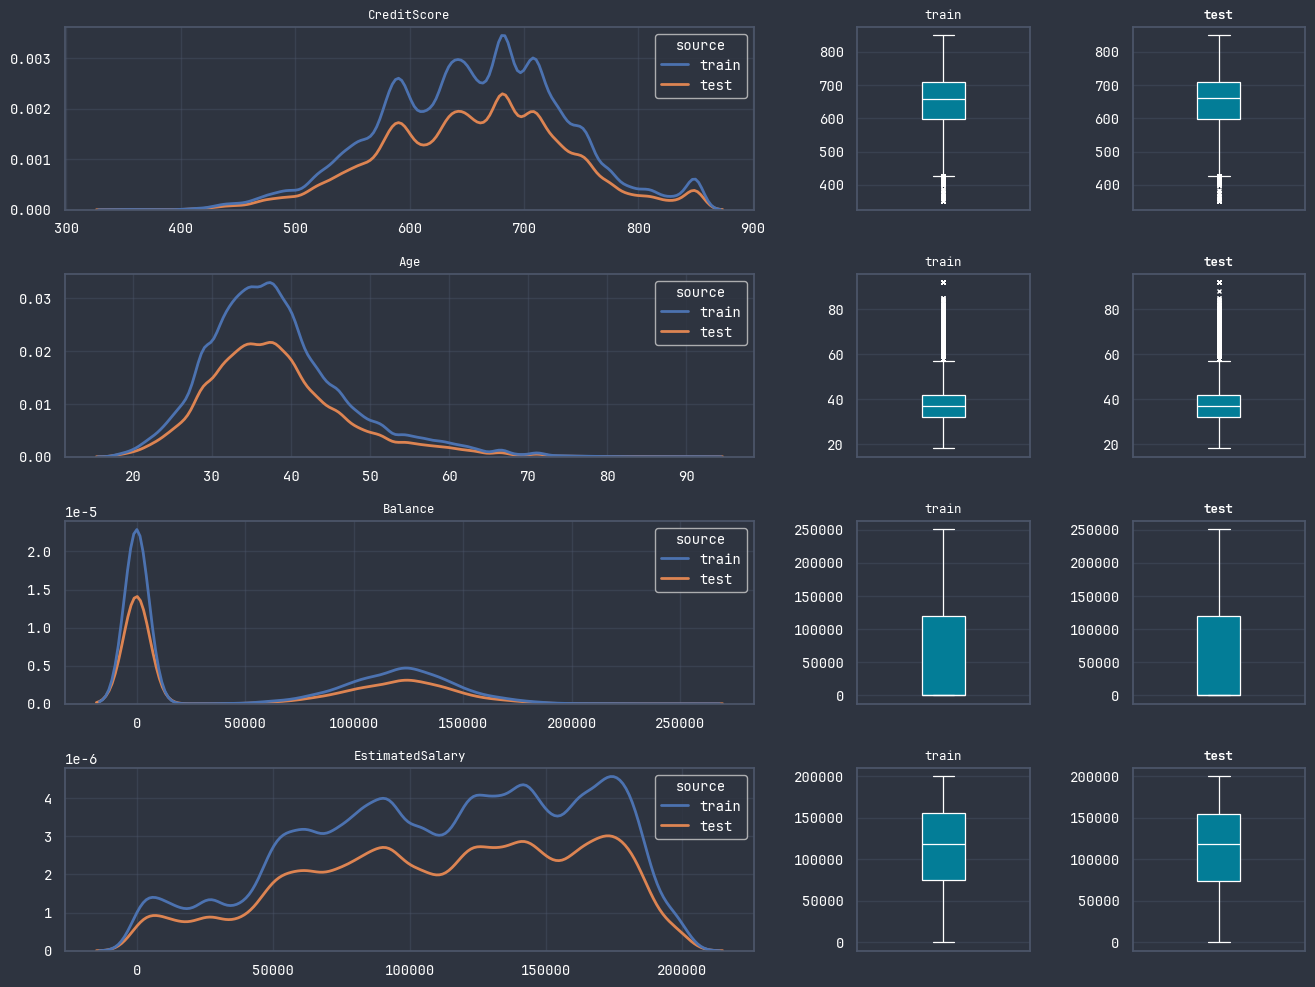

In [47]:
df = pd.concat([train_df[num_features].assign(source='train'), test_df[num_features].assign(source='test')], ignore_index=True)

fig, axs = plt.subplots(nrows=len(num_features), ncols=3, figsize=(16, len(num_features) * 3),
                        gridspec_kw= {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.8, 0.2, 0.2]})

for i, feat in enumerate(num_features):
    sns.kdeplot(data=df[[feat, 'source']], x=feat, hue='source', linewidth=2, ax=axs[i, 0])
    axs[i, 0].set_title(feat, fontsize=9)
    axs[i, 0].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'train', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, ax=axs[i, 1], **bp_props)
    axs[i, 1].set_title('train', fontsize=9)
    axs[i, 1].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'test', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, color='#037d97', ax=axs[i, 2], **bp_props)
    axs[i, 2].set_title('test', fontsize=9, fontweight='bold')
    axs[i, 2].set(xlabel='', ylabel='')

plt.tight_layout()
plt.show()

# Feature Engineering

## Outliers

### Isolation Forest

In [58]:
iso = IsolationForest(contamination='auto', random_state=2024)

df = train_df.copy()[cat_features + num_features]
le = LabelEncoder()
df['Geography'] = le.fit_transform(df['Geography'])
df['Gender'] = le.fit_transform(df['Gender'])

outlier_preds = iso.fit_predict(df)
outlier_df = df[outlier_preds == -1]

print(f'Number of Outliers: {outlier_df.shape[0]}')
print(f'Percentage of Rows: {round(100 * outlier_df.shape[0] / df.shape[0], 2)}%')

Number of Outliers: 96439
Percentage of Rows: 58.44%


# Data Preprocessing

In [105]:
cleaned_train_df = train_df.copy()[cat_features + num_features + [target_var]]
cleaned_test_df = test_df.copy()[cat_features + num_features]
combined_df = pd.concat([cleaned_train_df, cleaned_test_df], ignore_index=True)

# Label Encoding
ohe = OneHotEncoder()
ohe_df = ohe.fit_transform(combined_df[['Geography', 'Tenure', 'NumOfProducts']])
combined_df = pd.concat([combined_df.drop(['Geography', 'Tenure', 'NumOfProducts'], axis=1), pd.DataFrame(ohe_df.toarray(), columns=ohe.get_feature_names_out())], axis=1)

le = LabelEncoder()
combined_df['Gender'] = le.fit_transform(combined_df['Gender'])

cleaned_train_df = combined_df[~combined_df[target_var].isnull()]
cleaned_test_df = combined_df[combined_df[target_var].isnull()].drop(target_var, axis=1)

# Model Evaluation

## Base Model

In [106]:
# Cross Fold Training
n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((cleaned_train_df.shape[0],))
oof_metric = []

final_train_df = cleaned_train_df.drop(target_var, axis=1)
target = cleaned_train_df[target_var]

for fold, (train_idx, test_idx) in enumerate(k_fold.split(final_train_df, target)):
    X_train, X_valid = final_train_df.iloc[train_idx], final_train_df.iloc[test_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[test_idx]
    
    model = LGBMClassifier(
        n_estimators=1000,
        max_depth=10,
        random_state=2023,
        verbose=-1
    )
    
    model.fit(
        X_train,
        y_train,
        eval_set=(X_valid, y_valid),
        eval_metric='auc',
        callbacks=[
            log_evaluation(0),
            early_stopping(50, verbose=0)
        ]
    )
    
    oof_preds = model.predict_proba(X_valid)[:, 1]
    train_oof_preds[test_idx] = oof_preds
    oof_metric.append(roc_auc_score(y_valid, oof_preds))
    
oof_metric = np.array(oof_metric)
overall_metric = roc_auc_score(target, train_oof_preds)
print(f'OOF Scores: {oof_metric}')
print(f'Mean Score: {oof_metric.mean()}')
print(f'Standard Deviation: {oof_metric.std()}')
print('')
print(f'Overall Result: {overall_metric}')
print('')
print(f'{oof_metric}, {oof_metric.mean()}, {oof_metric.std()}, {overall_metric}')

OOF Scores: [0.89203114 0.88842992 0.88969593 0.88814989 0.88802554]
Mean Score: 0.8892664830165223
Standard Deviation: 0.0015042802698160287

Overall Result: 0.8891875166911795

[0.89203114 0.88842992 0.88969593 0.88814989 0.88802554], 0.8892664830165223, 0.0015042802698160287, 0.8891875166911795


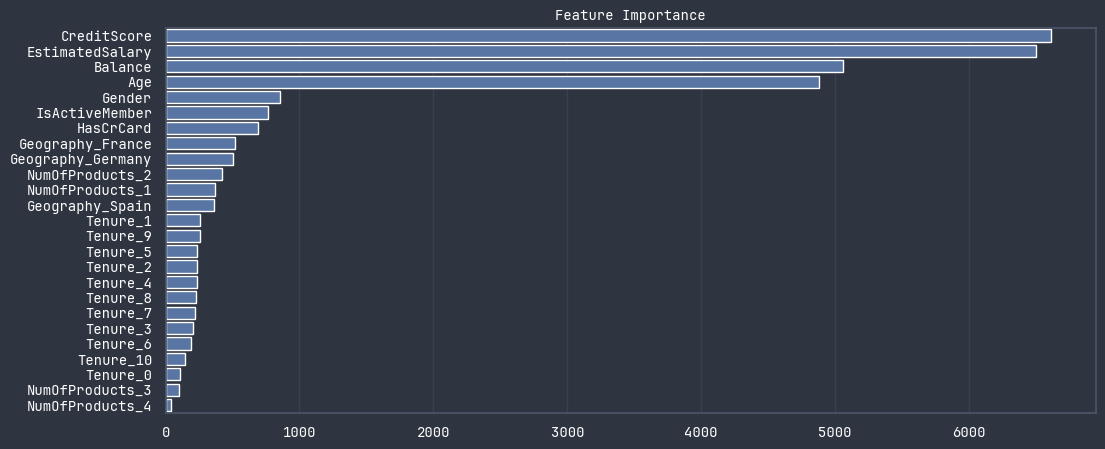

In [107]:
model = LGBMClassifier(
        n_estimators=1000,
        max_depth=10,
        random_state=2023,
        verbose=-1
    )
model.fit(cleaned_train_df.drop(target_var, axis=1), cleaned_train_df[target_var])

feat_imp = pd.DataFrame({
    'feat': cleaned_train_df.drop(target_var, axis=1).columns,
    'importance': model.feature_importances_
})
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

fig = plt.figure(figsize=(12, 0.2*len(feat_imp)))
sns.barplot(data=feat_imp, x='importance', y='feat')
plt.title('Feature Importance')
plt.xlabel('')
plt.ylabel('')
plt.show()

# Submission

In [113]:
test_preds = model.predict_proba(cleaned_test_df)[:, 1]

submission = pd.read_csv('sample_submission.csv')
submission['Exited'] = test_preds
submission.to_csv('submission.csv', index=False)